# ABIDE Subtype analysis
The goal of this notebook is to run a subtype analysis on the ABIDE dataset and to look at the subtype weights following Pierre Orban's analysis. Here are the central research questions:

1. What are subtypes of scores maps for different networks (7 network resolution on Cambridge) and how do they look like?
2. What are the individual subject weights for these subtypes (violin plots and Pierre's matrix)
3. For which networks and subtypes is diagnosis a significant predictor of weights?
4. What do weights for these subtypes and networks look like for patients and healthy controls?
5. For which networks and subtypes are dimensional scores like IQ significant predictors of weights?
5. What does the scatterplot of weights over IQ look like?

In [48]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import nilearn as nil
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as slin
from statsmodels.sandbox import stats as sts
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.sandbox.stats import multicomp as smi

In [49]:
%matplotlib inline

# Paths

In [50]:
# Paths
scale = 7
name = 'n308_sample'
mtp = 'stability_maps'
prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale{:03d}.nii.gz'.format(scale)
pheno_path = '/data1/abide/Pheno/unconstrained_2box_308_sample.csv'
netstack_path = '/data1/subtypes/serial_preps/netstack_demeaned_{}_scale_{:03d}.npy'.format(name, scale)
netraw_path = '/data1/subtypes/serial_preps/netstack_raw_{}_scale_{:03d}.npy'.format(name, scale)
corrmat_path = '/data1/subtypes/serial_preps/correlation_matrix_{}_scale_{:03d}.npy'.format(name, scale)
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
out_path = '/data1/subtypes/sc12'

In [51]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [52]:
# Get the phenotype data
pheno = pd.read_csv(pheno_path)

# Define some functions and the niak colormap

## Build the subtypes and compute the weights

In [53]:
# Load the serialized netstack
netstack = np.load(netstack_path)
corr_mat = np.load(corrmat_path)

In [54]:
# Make the grand average
gdavg = np.zeros(mask.shape + (scale,))

In [55]:
netraw = np.load(netraw_path)

In [56]:
subtypes = 5

scale = netstack.shape[0]
n_sub = netstack.shape[2]
n_vox = netstack.shape[1]

link_store = np.zeros((n_sub-1,4,scale))
part_store = np.zeros((scale, n_sub))
sbt_store = np.zeros((scale, subtypes, n_vox))
weight_store = np.zeros((scale, subtypes, n_sub))

# Iterate through the networks
for net_id in range(scale):
    # Compute linkage with Ward's criterion
    link_mat = scl.hierarchy.linkage(corr_mat[net_id, ...] , method='ward')
    link_store[..., net_id] = link_mat
    # Partition the linkage to get a given number of subtypes
    part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
    part_store[net_id, :] = part_sub

    sub_stack = np.zeros((n_vox, subtypes))
    for s_id in range(subtypes):
        sbt = np.mean(netstack[net_id, :, part_sub==s_id+1],0)
        sub_stack[:,s_id] = sbt
        sbt_store[net_id, s_id, :] = sbt

    # Init store - Compute the weights
    for s_id in range(subtypes):
        type_map = sub_stack[:, s_id]
        weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])

    # Init store - Compute the weights
    for s_id in range(subtypes):
        type_map = sub_stack[:, s_id]
        weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])

In [57]:
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
#cov = cov_list[1]
cov = 'VIQ'
cov_index = pd.notnull(pheno.replace(-9999, np.nan)[cov])
        
cov_pheno = pheno[cov_index]
# Generate the model matrix
factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = cov_pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
#other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Demean the covariate
other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

cov_weight = weight_store[..., cov_index.values]

res_store = list()
pval_store = np.zeros((scale, subtypes))
for net_id in range(scale):
    res_list = list()
    # Loop through the subtypes
    for s_id in range(subtypes):
        model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
        results = model.fit()
        # Save the p-values
        pval_store[net_id, s_id] = results.pvalues[cov]
        res_list.append(results)
    res_store.append(res_list)
    
# Now look at the mask of p-values passing FDR Correction
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)

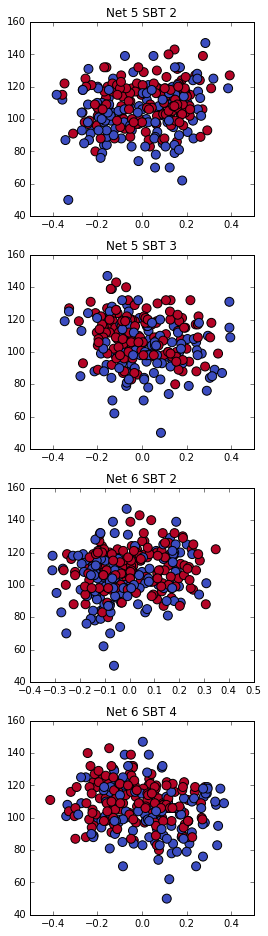

In [58]:
n_hits = np.argwhere(pcorr_store).shape[0]
fig = plt.figure(figsize=(4,4*n_hits))
for pid, hit in enumerate(np.argwhere(pcorr_store)):
    ax = fig.add_subplot(n_hits,1, pid+1)
    # Unpack coordinates
    (hx, hy) = hit
    weights = weight_store[hx, hy, cov_index.values]
    covs = cov_pheno[cov].values
    diag = cov_pheno['DX_GROUP'].values
    # Make a scatterplot
    ax.scatter(weights, covs, marker='o', s=80, linewidths=1, c=diag, cmap=plt.cm.coolwarm)
    ax.set_title('Net {} SBT {}'.format(hx, hy))